In [160]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import matplotlib
import ipyparams

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import func_optimize as fo
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
import neurolib.dashboard.layout as layout
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

cmap_ = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors_rgba()
exc_red = cmap_(3)
inh_blue=cmap_(0)
green = cmap_(2)
orange = cmap_(1)
purple = cmap_(4)
brown = cmap_(5)
pink = cmap_(6)
grey = cmap_(7)
lightgreen = cmap_(8)
lightblue = cmap_(9)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [162]:
points_0 = np.array( [ [0.4, 0.35], [0.4, 0.4], [0.45, 0.4], [0.425, 0.45], [0.475, 0.45], [0.45, 0.5],
                    [0.5, 0.5], [0.45, 0.65], [0.5, 0.65], [0.55, 0.65] ])

point_1 = np.array( [ [0.4, 0.322] ])

In [163]:
params_list = ['task', 'point', 'cost_params', 'init', 'init_vars', 'target', 'sigma', 'N_array',
               'it_array', 'cost', 'rep_ind']

In [164]:
dur = 500.
dt = 0.1
T = int(dur/dt +1)
dur_pre = 10
dur_post=10
trans_time = 0.8
prec_vars = [0,1]

c_m1 = pink
c_m2 = green
c_m3 = lightblue
c_m4 = orange

In [165]:
import ipyparams
nb = ipyparams.notebook_name
point = int(0)

dict_file = "OU_1E.pickle"
file = open(dict_file, "rb")
d = pickle.load(file)[0]
file.close()

dict_file = "OU_1I.pickle"
file = open(dict_file, "rb")
dI = pickle.load(file)[0]
file.close()

cost_uncontrolled = np.zeros(( len(d['sigma']) ))

In [167]:
aln.params.ext_exc_current = d['point'][0] * 5.
aln.params.ext_inh_current = d['point'][1] * 5.
noise_realizations_final = 10000

aln.params.duration = dur
setinit(d['init_vars'], aln)

for i_sig in range(len(d['sigma'])):
    
    if cost_uncontrolled[i_sig] > 0.:
        continue
        
    print(i_sig)
    
    aln.params.sigma_ou = d['sigma'][i_sig]
    target_ = d['target'][i_sig].copy()
    
    for t in range(target_.shape[2]):
        if t < T*trans_time:
            target_[:,:,t] = -1000.

    control_init = aln.getZeroControl()
    cost_final = 0.

    for j in range(noise_realizations_final):
        state_ = fo.updateState(aln, control_init)
        cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][i_sig][0],
                                                       state_, target_, list([0,1]) )


    cost_uncontrolled[i_sig] = cost_final/noise_realizations_final

2


[1386.66286762  640.0167983   282.01765448]
5.708310918519151 39.707728677817244


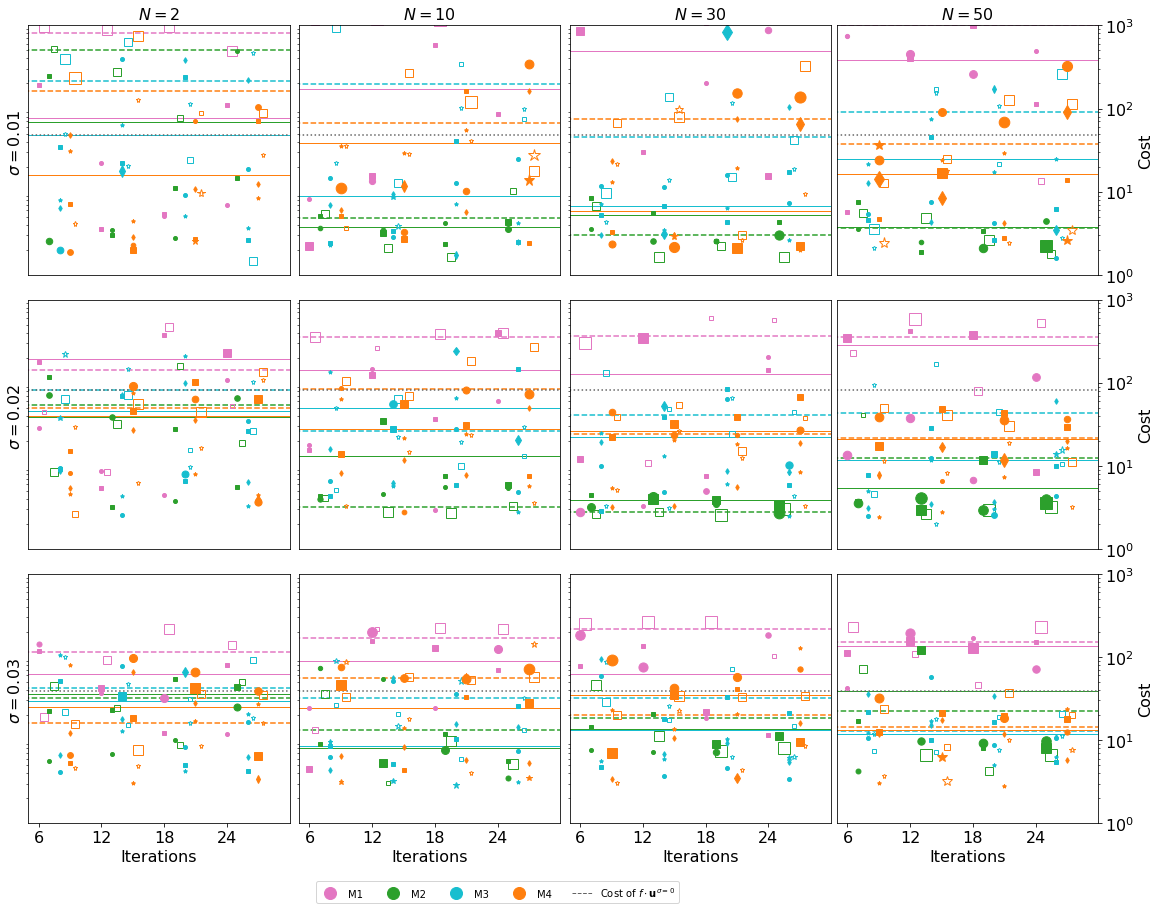

In [222]:
dict_file = "OU_1E.pickle"
file = open(dict_file, "rb")
d = pickle.load(file)[point]
file.close()

dict_file = "OU_1E_transtime.pickle"
file = open(dict_file, "rb")
d_t = pickle.load(file)[point]
file.close()

dict_file = "OU_1I.pickle"
file = open(dict_file, "rb")
dI = pickle.load(file)[point]
file.close()

rows = len(d['sigma'])
columns = len(d['N_array'])
fs_ = 16
msmax_ = 12
msmin_ = 4
x_array = d['it_array']
x_tick_array = [6,12,18,24]
clist = [c_m1, c_m2, c_m3, c_m4]  

replist = []

for m_ind in range(4):
    for st_ind in range(2):
        for s_ind in range(rows):
            for n_ind in range(columns):
                for it_ind in range(len(d['it_array'])):

                    if (d['rep_ind'][s_ind,m_ind,st_ind,n_ind,it_ind] > 0. and
                        d['cost'][s_ind,m_ind,st_ind,n_ind,it_ind] < 100.):
                        replist.append(d['rep_ind'][s_ind,m_ind,st_ind,n_ind,it_ind])
                    if (dI['rep_ind'][s_ind,m_ind,st_ind,n_ind,it_ind] > 0. and
                        dI['cost'][s_ind,m_ind,st_ind,n_ind,it_ind] < 100.):
                        replist.append(dI['rep_ind'][s_ind,m_ind,st_ind,n_ind,it_ind])

                        
max_repind = np.median(replist)
min_repind = min(replist)

print(cost_uncontrolled)
print(min_repind, max_repind)

def msf(repind):
    result = msmin_ + ( (msmax_-msmin_) * ( 1. -
                ( min(repind, max_repind) - min_repind ) / (max_repind - min_repind) ) )
    return  result

fig, ax = plt.subplots( rows,columns, figsize=(16,12), constrained_layout=True)
for s_ind in range(rows):
    for n_ind in range(columns):
        
        cost_list_E = [ [], [], [], [] ]
        cost_list_I = [ [], [], [], [] ]
        
        for it_ind in range(1,len(x_array)):
            it = x_array[it_ind]

            for i in range(4):
                if d['cost'][s_ind, i, 0, n_ind, it_ind] > 0.:
                    cost_list_E[i].append(d['cost'][s_ind, i, 0, n_ind, it_ind])
                if dI['cost'][s_ind, i, 0, n_ind, it_ind] > 0.:
                    cost_list_I[i].append(dI['cost'][s_ind, i, 0, n_ind, it_ind])
                
                ax[s_ind,n_ind].plot(it+i, d['cost'][s_ind, i, 0, n_ind, it_ind],
                    color=clist[i], linestyle='', marker='s',
                    markersize=msf(d['rep_ind'][s_ind, i, 0, n_ind, it_ind]))
                
                ax[s_ind,n_ind].plot(it+i, d_t['cost'][s_ind, i, 0, n_ind, it_ind],
                    color=clist[i], linestyle='', marker='o',
                    markersize=msf(d_t['rep_ind'][s_ind, i, 0, n_ind, it_ind]))
                
                ax[s_ind,n_ind].plot(it+i+0.5, dI['cost'][s_ind, i, 0, n_ind, it_ind],
                    color=clist[i], linestyle='', marker='s',fillstyle='none',
                    markersize=msf(dI['rep_ind'][s_ind, i, 0, n_ind, it_ind]))
                
                if i > 1:                    
                    if d['cost'][s_ind, i, 1, n_ind, it_ind] > 0.:
                        cost_list_E[i].append(d['cost'][s_ind, i, 1, n_ind, it_ind])
                if dI['cost'][s_ind, i, 1, n_ind, it_ind] > 0.:
                    cost_list_I[i].append(dI['cost'][s_ind, i, 1, n_ind, it_ind])
                    
                    ax[s_ind,n_ind].plot(it+i, d['cost'][s_ind, i, 1, n_ind, it_ind],
                        color=clist[i], linestyle='', marker='*',
                        markersize=msf(d['rep_ind'][s_ind, i, 1, n_ind, it_ind]))
                    ax[s_ind,n_ind].plot(it+i+0.5, dI['cost'][s_ind, i, 1, n_ind, it_ind],
                            color=clist[i], linestyle='', marker='*',fillstyle='none',
                            markersize=msf(d['rep_ind'][s_ind, i, 1, n_ind, it_ind])+1)
                    ax[s_ind,n_ind].plot(it+i, d_t['cost'][s_ind, i, 1, n_ind, it_ind],
                        color=clist[i], linestyle='', marker='d',
                        markersize=msf(d_t['rep_ind'][s_ind, i, 1, n_ind, it_ind]))
        for i in range(4):
            ax[s_ind,n_ind].hlines(np.mean(cost_list_E[i]), 0, 30, color=clist[i], linewidth=1)
            ax[s_ind,n_ind].hlines(np.mean(cost_list_I[i]), 0, 30, color=clist[i], linestyle='--')
        ax[s_ind,n_ind].hlines(cost_noisefree[s_ind], 0, 30, color=darkgrey, linestyle='dotted')
        #ax[s_ind,n_ind].hlines(cost_uncontrolled[s_ind], 0, 30, color=darkgrey, linestyle='dashdot')
        
for r in range(rows):
    for c in range(columns):
        ax[r,c].set_ylim(1,1000)
        ax[r,c].set_xlim(5,30)
        ax[r,c].tick_params(axis='x', labelsize=fs_)
        ax[r,c].tick_params(axis='y', labelsize=fs_)
        
        ax[r,c].set_xticks([])
        ax[r,c].grid(False)
        ax[r,c].set_yscale('log')
        ax[r,c].set_yticks([])
        
for r in range(rows):
    ax[r,-1].set_yticks([1,10,100,1000])
    ax[r,-1].set_ylabel('Cost', fontsize=fs_)
    ax[r,-1].yaxis.set_label_position("right")
    ax[r,-1].yaxis.tick_right()
    ax[r,0].text(-0.05,0.4, r'$\sigma=$'+'{:.2f}'.format(d['sigma'][r]), rotation=90, size=fs_,
                 verticalalignment='bottom', horizontalalignment='center', transform=ax[r,0].transAxes)
    

for c in range(columns):
    ax[-1,c].set_xticks(x_tick_array)
    ax[-1,c].set_xlabel('Iterations', fontsize=fs_)
    ax[0,c].set_title(r'$N=$'+'{}'.format(d['N_array'][c]), fontsize=fs_)
        
legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color=c_m1, label='M1', markersize=msmax_, lw=0),
                  matplotlib.lines.Line2D([0], [0], marker='o', color=c_m2, label='M2', markersize=msmax_, lw=0),
                  matplotlib.lines.Line2D([0], [0], marker='o', color=c_m3, label='M3', markersize=msmax_, lw=0),
                  matplotlib.lines.Line2D([0], [0], marker='o', color=c_m4, label='M4', markersize=msmax_, lw=0),
                  matplotlib.lines.Line2D([0], [0], marker=None, color=darkgrey,
                            label=r'Cost of $f\cdot \mathbf{u}^{\sigma=0}$', lw=1, linestyle='--'),
                  #matplotlib.lines.Line2D([0], [0], marker=None, color=darkgrey, label='Cost uncontrolled',
                  #          lw=1, linestyle='dashdot')
                  ]
fig.legend(handles=legend_elements, ncol=6, bbox_to_anchor=(0.59, -0.01))

filename_ = 'OU1_point' + str(point) + '.png'   
savepath_writing = (os.getcwd().split('neurolib')[0] + 'writing' + os.sep + 'paper2_chaos' + os.sep + 'chaos'
                    + os.sep + 'images')
fig.savefig(os.path.join(savepath_writing, filename_), bbox_inches='tight')
plt.show()

In [207]:
print(d['cost'][0,2,0,3,:])
print(np.mean(d['cost'][0,2,0,3,:]))
print(d['rep_ind'][2,0,0,3,:])

[1388.29795058    0.            0.            0.            0.        ]
277.65959011602615
[ 0.         33.59234459 22.50452179 13.50238319 36.63362823]


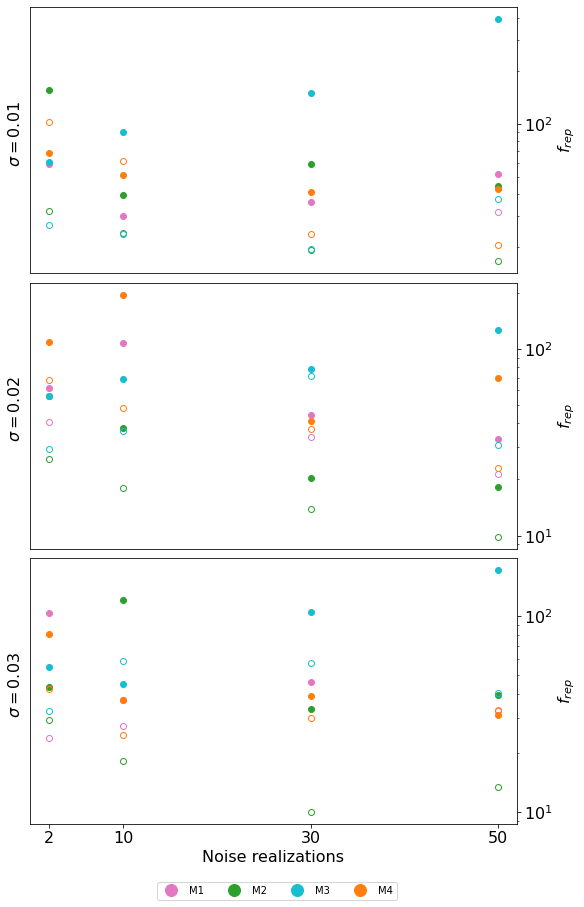

In [223]:
dict_file = "OU_1E.pickle"
file = open(dict_file, "rb")
d = pickle.load(file)[point]
file.close()

dict_file = "OU_1I.pickle"
file = open(dict_file, "rb")
dI = pickle.load(file)[point]
file.close()

row = len(d['sigma'])
columns = 1
ms_ = 6

#print(min_repind, max_repind)  

fig, ax = plt.subplots( rows,columns, figsize=(8,12), constrained_layout=True)
for s_ind in range(rows):
    for n_ind in range(len(d['N_array'])):
        
        rep_list_E = [ [], [], [], [] ]
        rep_list_I = [ [], [], [], [] ]
        
        for it_ind in range(1,len(x_array)):
            it = x_array[it_ind]

            for i in range(4):
                if ( d['rep_ind'][s_ind, i, 0, n_ind, it_ind] > 0.
                    and d['cost'][s_ind, i, 0, n_ind, it_ind] < 100.):
                    rep_list_E[i].append(d['rep_ind'][s_ind, i, 0, n_ind, it_ind])
                if ( dI['rep_ind'][s_ind, i, 0, n_ind, it_ind] > 0.
                    and dI['cost'][s_ind, i, 0, n_ind, it_ind] < 100.):
                    rep_list_I[i].append(dI['rep_ind'][s_ind, i, 0, n_ind, it_ind])
                
                if i > 1:                    
                    if ( d['rep_ind'][s_ind, i, 1, n_ind, it_ind] > 0.
                    and d['cost'][s_ind, i, 1, n_ind, it_ind] < 100.):
                        rep_list_E[i].append(d['rep_ind'][s_ind, i, 1, n_ind, it_ind])
                    if ( dI['rep_ind'][s_ind, i, 1, n_ind, it_ind] > 0.
                    and dI['cost'][s_ind, i, 1, n_ind, it_ind] < 100.):
                        rep_list_I[i].append(dI['rep_ind'][s_ind, i, 1, n_ind, it_ind])
           
        for i in range(4):
            ax[s_ind].plot(d['N_array'][n_ind], np.median(rep_list_E[i]), color=clist[i], marker='o')
            ax[s_ind].plot(d['N_array'][n_ind], np.median(rep_list_I[i]), color=clist[i], marker='o',
                           fillstyle='none')
        
for r in range(rows):
        
        #ax[r].set_ylim(0.3,50)
        ax[r].set_xlim(0,52)
        ax[r].tick_params(axis='x', labelsize=fs_)
        ax[r].tick_params(axis='y', labelsize=fs_)
        
        ax[r].set_xticks([])
        ax[r].grid(False)
        ax[r].set_yscale('log')
        #ax[r].set_yticks([])
        
for r in range(rows):
    #ax[r].set_yticks([0.3, 1., 10, 50])
    ax[r].set_ylabel(r'$f_{rep}$', fontsize=fs_)
    ax[r].yaxis.set_label_position("right")
    ax[r].yaxis.tick_right()
    ax[r].text(-0.03,0.4, r'$\sigma=$'+'{:.2f}'.format(d['sigma'][r]), rotation=90, size=fs_,
                 verticalalignment='bottom', horizontalalignment='center', transform=ax[r].transAxes)
    

ax[-1].set_xticks([2,10,30,50])
ax[-1].set_xlabel('Noise realizations', fontsize=fs_)
        
legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color=c_m1, label='M1', markersize=msmax_, lw=0),
                  matplotlib.lines.Line2D([0], [0], marker='o', color=c_m2, label='M2', markersize=msmax_, lw=0),
                  matplotlib.lines.Line2D([0], [0], marker='o', color=c_m3, label='M3', markersize=msmax_, lw=0),
                  matplotlib.lines.Line2D([0], [0], marker='o', color=c_m4, label='M4', markersize=msmax_, lw=0),
                  
                  ]
fig.legend(handles=legend_elements, ncol=6, bbox_to_anchor=(0.69, -0.01))

filename_ = 'OU1_point' + str(point) + 'rep.png'   
savepath_writing = (os.getcwd().split('neurolib')[0] + 'writing' + os.sep + 'paper2_chaos' + os.sep + 'chaos'
                    + os.sep + 'images')
fig.savefig(os.path.join(savepath_writing, filename_), bbox_inches='tight')
plt.show()

(1, 6, 5001)


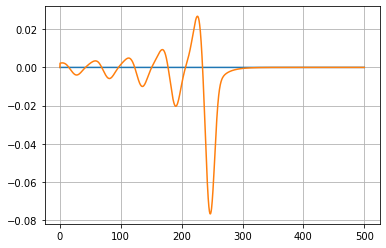

In [129]:
trange = [100,5101]

noisefree_file = ".." + os.sep + '..' + os.sep + '..' + os.sep + 'data_2' + os.sep + 'high_osc' + os.sep + '1_I.pickle'
file = open(noisefree_file, "rb")
noisefree = pickle.load(file)
file.close()

noisefree_c = noisefree[0][:,:,trange[0]:trange[1]]
print( noisefree_c.shape )

plt.plot(np.arange(0, dur+0.1, 0.1), noisefree_c[0,0,:])
plt.plot(np.arange(0, dur+0.1, 0.1), noisefree_c[0,1,:])
plt.show()

aln = ALNModel()
N = aln.params.N
data.set_parameters(aln)

T = int(dur / dt)

aln.params.ext_exc_current = d['point'][0] * 5.
aln.params.ext_inh_current = d['point'][1] * 5.
noise_realizations_final = 10000

aln.params.duration = dur
setinit(d['init_vars'], aln)

factor = np.zeros(( len(d['sigma']) ))
cost_noisefree = np.zeros(( len(d['sigma']) ))

In [157]:
noise_realizations_final = 10000

aln = ALNModel()
N = aln.params.N
data.set_parameters(aln)

aln.params.ext_exc_current = d['point'][0] * 5.
aln.params.ext_inh_current = d['point'][1] * 5.

for i_sig in range(len(d['sigma'])):
        
    f_ = np.arange(1.7, 3.2, .1)
    c_ = np.zeros(( len(f_) ))
    aln.params.sigma_ou = d['sigma'][i_sig]
    target_ = d['target'][i_sig].copy()
        
    for t in range(target_.shape[2]):
        if t < T*trans_time:
            target_[:,:,t] = -1000.
            
    minind = -1
    minc = 1000.
    
    for f_ind in range(len(f_)):
        
        if i_sig == 1 and f_ > 2.:
            continue
        elif i_sig == 2 and f_ < 2.:
            continue
        elif i_sig == 2 and f_ > 2.5:
            continue
        elif i_sig == 3 and f_ < 2.2:
            continue
        
        if c_[f_ind] != 0.:
            continue
        
        print(f_ind)
        
        control_init = aln.getZeroControl()
        control_init = f_[f_ind] * noisefree_c[:,:,:]
        cost_final = 0.
        
        aln.params.duration = dur
        setinit(d['init_vars'], aln)
        
        c_s = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][i_sig][2],
                                                           dt, control_init)
                
        for j in range(noise_realizations_final):
            state_ = fo.updateState(aln, control_init)
            #plt.plot(aln.t, aln.rates_exc[0,:])
            #plt.plot(aln.t, aln.rates_inh[0,:])
            
            cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][i_sig][0],
                                                           state_, target_, list([0,1]) )
            
        #plt.show(cost_final)

        c_[f_ind] = cost_final/noise_realizations_final + c_s

        if c_[f_ind] < minc:
            minc = c_[f_ind]
            minind = f_ind
            
                        
    print(c_)
            
    factor[i_sig] = f_[minind]
    cost_noisefree[i_sig] = minc
            
print(factor)
print(cost_noisefree)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[ 68.44242653  50.07970617  47.48180215  48.14389787  53.11868572
  57.61860949  65.87015269  76.90173338  90.94864938 106.84775088
 122.35388509 137.33739798 153.66192314 160.24658861 183.00019166
 193.75946832]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [137]:
factor = [1.8, 2.8, 2.9]
cost_noisefree = [64.88213161, 63.28490779, 28.13466296]

In [108]:
# COMPUTE CONTROL

i_n = 3
i_it = 3
s_ind_array = [0,2]

tol = 1e-16
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])
maxC = [5., -5., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

control_DU0 = []
cost_DU0 = []

for s_ind in s_ind_array:
    aln.params.sigma_ou = d['sigma'][s_ind]

    aln.params.duration = dur
    control_init = aln.getZeroControl()
    cost.setParams(d['cost_params'][s_ind][0], d['cost_params'][s_ind][1], d['cost_params'][s_ind][2])

    target_ = d['target'][s_ind].copy()

    for t in range(target_.shape[2]):
        if t < T*trans_time:
            target_[:,:,t] = -1000.

    aln.params.duration = dur
    setinit(d['init_vars'], aln)
    
    c_vars = [0]
    if s_ind != 0:
        c_vars = [1]

    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
        control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = 3,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=d['N_array'][i_n], init_params = d['init_vars'], method='M2')

    control_init = bc[:,:,100:-100]

    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
        control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = d['it_array'][i_it]-3,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=d['N_array'][i_n], init_params = d['init_vars'], method='M2')

    control_DU0.append(bc[:,:,100:-100])

    cost_final = 0.    
    c_s = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2],
                                                           dt, control_DU0[-1])

    aln.params.duration = dur
    setinit(d['init_vars'], aln)

    for j in range(noise_realizations_final):
        state_ = fo.updateState(aln, control_DU0[-1])
        cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                       state_, target_, list([0,1]) )

    cost_DU0.append(cost_final/noise_realizations_final + c_s)
    
    print(cost_DU0)

set cost params:  0.020814635113714494 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1395.2487655287819
Gradient descend method:  None
RUN  1 , total integrated cost =  204.32709893044955
step size too small or too large
RUN  2 , total integrated cost =  99.93139706710365
RUN  3 , total integrated cost =  2.162949150314432
RUN  3 , total integrated cost mean =  2.162949150314432
Improved over  3  iterations in  76.50314366997918  seconds by  99.84497752631985  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.9498605534337117
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  1.6468933135755708
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small 

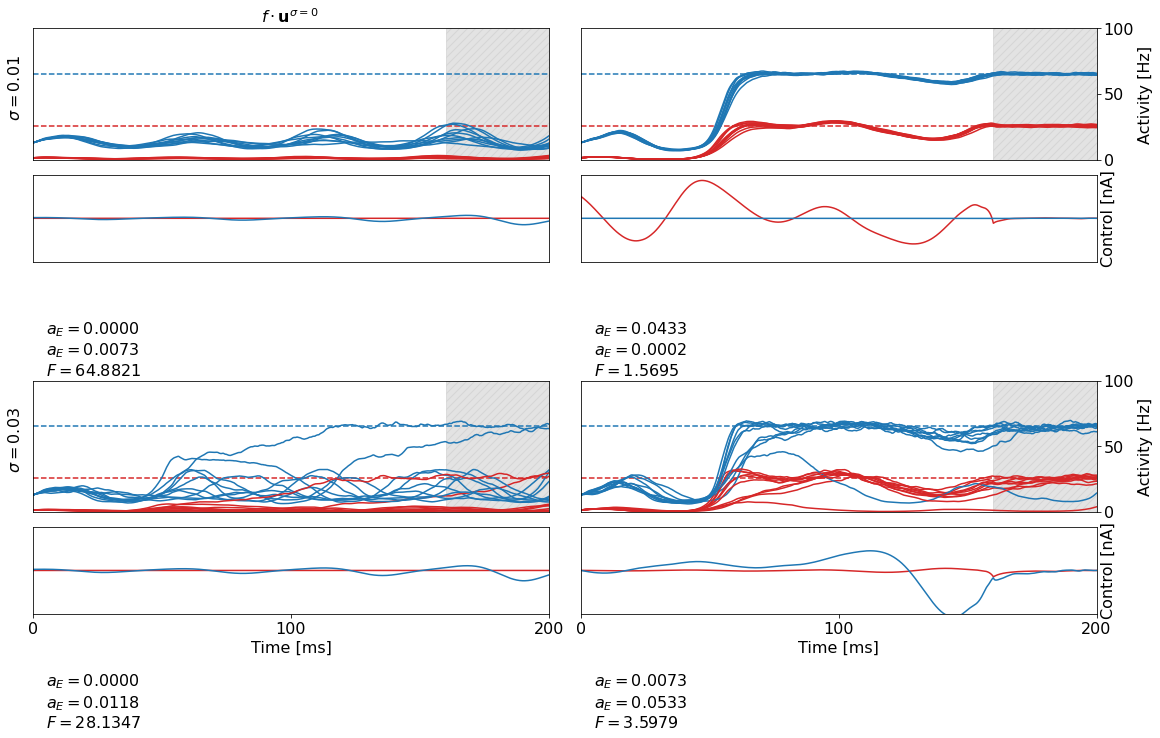

In [111]:
rows = 4
columns = 2

fig, ax = plt.subplots(rows, columns, figsize=(16,10), constrained_layout=True,
                       gridspec_kw={'height_ratios': [3,2,3,2]})
plot_realizations = 10

s_ind = 0

t_array = np.arange(0,dur+dt,dt)
ax[0,0].set_title(r'$f\cdot \mathbf{u}^{\sigma=0}$ ', fontsize=fs_)

setinit(d['init_vars'], aln)
aln.params.duration = dur

for r in range(2):

    ax[2*r+1,1].plot( t_array, control_DU0[r][0,0,:]/5., color=exc_red)
    ax[2*r+1,1].plot( t_array, control_DU0[r][0,1,:]/5., color=inh_blue)
    ax[2*r+1,1].text( 5., -0.18, r'$a_E=$' + '{:.4f}'.format(np.amax(np.abs(control_DU0[r][0,0,:]))/5.) +'\n'
                 + r'$a_E=$' + '{:.4f}'.format(np.amax(np.abs(control_DU0[r][0,1,:]))/5.) +'\n'
                 + r'$F=$' + '{:.4f}'.format(cost_DU0[r]), fontsize=fs_ )

s_ind = 0
ax[1,0].plot( t_array, factor[s_ind] * noisefree_c[0,0,:]/5., color=exc_red)
ax[1,0].plot( t_array, factor[s_ind] * noisefree_c[0,1,:]/5., color=inh_blue)
ax[1,0].text( 5., -0.18, r'$a_E=$' + '{:.4f}'.format(factor[s_ind] * np.amax(np.abs(noisefree_c[0,0,:]))/5.) +'\n'
                 + r'$a_E=$' + '{:.4f}'.format(factor[s_ind] * np.amax(np.abs(noisefree_c[0,1,:]))/5.) +'\n'
                 + r'$F=$' + '{:.4f}'.format(cost_noisefree[s_ind]), fontsize=fs_ )

for c in range(columns):
    ax[0,c].hlines( d['target'][s_ind][0,0,-1], 0, dur, linestyle='--', color=exc_red)
    ax[0,c].hlines( d['target'][s_ind][0,1,-1], 0, dur, linestyle='--', color=inh_blue)
    
aln.params.sigma_ou = d['sigma'][s_ind]
    
for indexx in range(plot_realizations):
    aln.run(control = control_DU0[0])
    ax[0,1].plot( t_array, aln.rates_exc[0,:], color=exc_red)
    ax[0,1].plot( t_array, aln.rates_inh[0,:], color=inh_blue)
    aln.run(control = factor[s_ind] * noisefree_c[:,:,:])
    ax[0,0].plot( t_array, aln.rates_exc[0,:], color=exc_red)
    ax[0,0].plot( t_array, aln.rates_inh[0,:], color=inh_blue)
    
    
ax[0,0].text(-10,30., r'$\sigma=$'+'{:.2f}'.format(d['sigma'][s_ind]), rotation=90, size=fs_,
                 verticalalignment='bottom')

s_ind = 2
ax[3,0].plot( t_array, factor[s_ind] * noisefree_c[0,0,:]/5., color=exc_red)
ax[3,0].plot( t_array, factor[s_ind] * noisefree_c[0,1,:]/5., color=inh_blue)
ax[3,0].text( 5., -0.18, r'$a_E=$' + '{:.4f}'.format(factor[s_ind] * np.amax(np.abs(noisefree_c[0,0,:]))/5.) +'\n'
                 + r'$a_E=$' + '{:.4f}'.format(factor[s_ind] * np.amax(np.abs(noisefree_c[0,1,:]))/5.) +'\n'
                 + r'$F=$' + '{:.4f}'.format(cost_noisefree[s_ind]),fontsize=fs_ )

for c in range(columns):
    ax[2,c].hlines( d['target'][s_ind][0,0,-1], 0, dur, linestyle='--', color=exc_red)
    ax[2,c].hlines( d['target'][s_ind][0,1,-1], 0, dur, linestyle='--', color=inh_blue)

aln.params.sigma_ou = d['sigma'][s_ind]
    
for indexx in range(plot_realizations):
    aln.run(control = control_DU0[0])
    ax[2,1].plot( t_array, aln.rates_exc[0,:], color=exc_red)
    ax[2,1].plot( t_array, aln.rates_inh[0,:], color=inh_blue)
    aln.run(control = factor[s_ind] * noisefree_c[:,:,:])
    ax[2,0].plot( t_array, aln.rates_exc[0,:], color=exc_red)
    ax[2,0].plot( t_array, aln.rates_inh[0,:], color=inh_blue)
    
ax[2,0].text(-10,30., r'$\sigma=$'+'{:.2f}'.format(d['sigma'][s_ind]), rotation=90, size=fs_,
                 verticalalignment='bottom')

for r in range(rows):
    for c in range(columns):
        ax[r,c].tick_params(axis='x', labelsize=fs_)
        ax[r,c].tick_params(axis='y', labelsize=fs_)
        ax[r,c].set_xlim(0,dur)
        ax[r,c].grid(False)
        ax[r,c].set_xticks([])
        ax[r,c].set_yticks([])
        ax[r,c].grid(False)
        
for r in [0,2]:
    ax[r,-1].set_yticks(np.arange(0,110,50))
    ax[r,-1].set_ylabel('Activity [Hz]', fontsize=fs_)
    ax[r,-1].yaxis.set_label_position("right")
    ax[r,-1].yaxis.tick_right()
    for c in range(columns):
        ax[r,c].axvspan( dur*trans_time, dur, facecolor=midgrey,
                            alpha=0.5, zorder=-1, hatch='///', edgecolor = midgrey)
for r in [1,3]:
    #ax[r,-1].set_yticks(np.arange(-0.2,0.051,0.1))
    ax[r,-1].set_ylabel('Control [nA]', fontsize=fs_)
    ax[r,-1].yaxis.set_label_position("right")
    ax[r,-1].yaxis.tick_right()
         
for c in range(columns):
    ax[-1,c].set_xlabel('Time [ms]', fontsize=fs_)
    ax[-1,c].set_xticks(np.arange(0,dur+1,100))
    ax[0,c].set_ylim(0,100)
    ax[2,c].set_ylim(0,100)
    ax[1,c].set_ylim(-0.05,0.05)
    ax[3,c].set_ylim(-0.05,0.05)
    
filename_ = 'DU1_traces_point' + str(point) + '.png'   
fig.savefig(os.path.join(savepath_writing, filename_), bbox_inches='tight')